In [2]:
import numpy as np
import pickle
from funcy                     import *
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers        import l2
from keras.utils               import plot_model
import keras.layers as kl

import psutil
import keras


# basic configs
weight_decay = 0.0005 
use_bias = False
weight_init="he_normal" 
padding = 'same'
L2 = keras.regularizers.l2(weight_decay)
conv_config = {'padding':padding,
               'kernel_initializer':weight_init,
               'kernel_regularizer':L2,
               'use_bias':use_bias}

# insuring image data channel is at last axis 
keras.backend.image_data_format()
# keras.backend..set_image_data_format('channels_first')

'channels_last'

In [ ]:
# Utility functions.

def ljuxt(*fs):  
    return rcompose(juxt(*fs), list)

def bn():return kl.BatchNormalization()

def relu():return kl.Activation('relu')

def conv(filter_size, kernel_size, stride_size=1):
    return kl.Conv2D(filter_size, kernel_size=kernel_size,strides=stride_size, **conv_config)

def conv3(filter_size):return conv(filter_size, kernel_size=(3,3), stride_size=1)
def conv1(filter_size):return conv(filter_size, kernel_size=(1,1), stride_size=1)

def add():return kl.Add()

def GlobalAvgPool():return kl.GlobalAveragePooling2D()

def avgPool(pool_size=2,strides=2):return kl.AveragePooling2D(pool_size=pool_size,strides=strides)

def dense(unit_size, activation):
    return kl.Dense(unit_size, activation=activation, kernel_regularizer=L2)  

# original layer which is pad the channel size with zeros matrix, 
# ex. padding (None,28,28,1) 2 zeros channels as (None,28,28,3)
class zeroPad(keras.engine.topology.Layer):
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        self.l = None
        super(zeroPad, self).__init__(**kwargs)

    def build(self, input_shape):
        super(zeroPad, self).build(input_shape)

    def call(self, x):
        x_shape = x.shape.as_list()
        if self.output_dim == x_shape[-1]:
            return x
        if self.l is None:
            padding = self.output_dim//x_shape[-1]
            self.l = [x] + [kl.K.zeros_like(x) for i in range(padding-1)]
            self.l +=  [kl.K.zeros_like(x)[:,:,:,:self.output_dim - padding*x_shape[-1]] ]
        return kl.concatenate(self.l)

    def compute_output_shape(self, input_shape):
        return (input_shape[0],input_shape[1],input_shape[2], self.output_dim)

# U-net architecture
![title](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [78]:
def conv_relu(filter_size, kernel_size, stride_size=1):
    return rcompose(conv(filter_size, kernel_size, stride_size),relu())

def bn_relu_conv(filter_size, kernel_size, stride_size=1):
    return rcompose(bn(),relu(),conv(filter_size, kernel_size, stride_size))

def conv_bn_relu(filter_size, kernel_size, stride_size=1):
    return rcompose(conv(filter_size, kernel_size, stride_size),bn(),relu())

def u_net_unit(fs,downSample=True):
    if downSample:return rcompose(kl.MaxPool2D(2,2),conv_relu(fs,3),conv_relu(fs,3))
    else:return rcompose(conv_relu(fs,3),conv_relu(fs,3),kl.UpSampling2D(size=2),conv_relu(fs,3))

def u_net(first=2**6,classes=1):
    fs = first*2**np.arange(1,5) 
    fs = iter(fs.tolist()+fs.tolist()[::-1][1:]+[first])# [128, 256, 512, 1024, 512, 256, 128, 64]
    return rcompose(
                    conv_relu(first,3),conv_relu(first,3),
                    rcompose(ljuxt(rcompose(u_net_unit(next(fs)),
                                           rcompose(ljuxt(rcompose(u_net_unit(next(fs)),
                                                                   rcompose(ljuxt(rcompose(u_net_unit(next(fs)),
                                                                                           rcompose(ljuxt(rcompose(u_net_unit(next(fs)),
                                                                                                                   kl.UpSampling2D(2),
                                                                                                                   conv_relu(next(fs),2),
                                                                                                                                           
                                                                                            ),identity),
                                                                                            kl.Concatenate(),
                                                                                            u_net_unit(next(fs),False),
                                                                                            ),
                                                               
                                                                    ),identity),
                                                                    kl.Concatenate(),
                                                                    u_net_unit(next(fs),False),
                                                                    ),
                                                               
                                            ),identity),
                                            kl.Concatenate(),
                                            u_net_unit(next(fs),False),),
                    ),identity),
                    kl.Concatenate(),
                    conv_relu(first,3),conv_relu(first,3),#conv3(first),conv3(first),
                    conv(classes,1,1),kl.Activation('sigmoid'),
                    ),
        )

In [79]:
x = kl.Input(shape=(512,512,1))
model = keras.models.Model(x, u_net()(x) )

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_500 (Conv2D)             (None, 512, 512, 64) 576         input_28[0][0]                   
__________________________________________________________________________________________________
activation_499 (Activation)     (None, 512, 512, 64) 0           conv2d_500[0][0]                 
__________________________________________________________________________________________________
conv2d_501 (Conv2D)             (None, 512, 512, 64) 36864       activation_499[0][0]             
__________________________________________________________________________________________________
activation

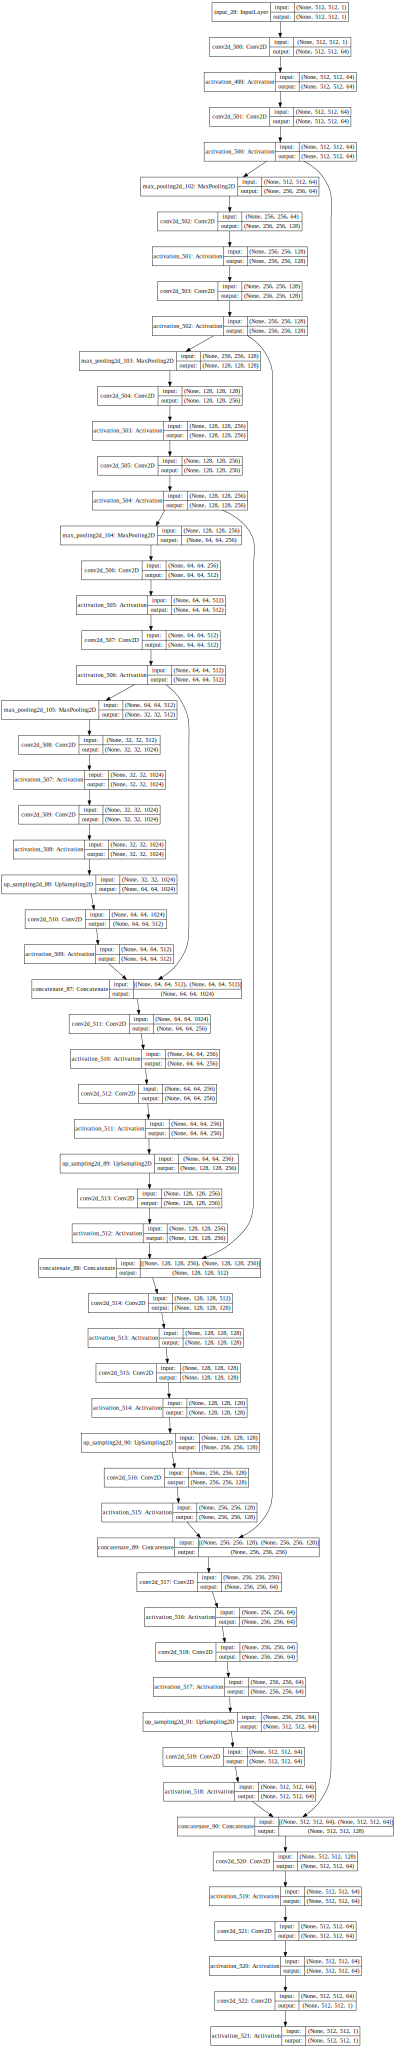

In [80]:
model.summary()
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))